In [1]:
from distributed import Client
client = Client(n_workers = 4, threads_per_worker=1, memory_limit='2GB')
client

Client Scheduler: tcp://127.0.0.1:45601 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.00 GB


***
## **Import features and define functions to be used**
***

In [4]:
import xarray as xr
from pathlib import Path
import collections
import cartopy.crs as ccrs
import cartopy.feature as cf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline

#Load netCDF files to work with
JetDs = xr.open_dataset(Path('/media/ot/Local Disk/download_2016.nc'))
RH_ds = xr.open_dataset(Path('/media/ot/Local Disk/RH_2016.nc'))

#create a function to group months into seasons
def seas_select(month, st, en):
    return((month >=st) & (month <=en))

#create a function to select specified time periods in hours
def hour_select(time, ts):
    return(time == ts)


#create a function to calculate wind direction of both u and v components
def wind_uv_to_dir(u,v):
    WDir = (270-np.rad2deg(np.arctan2(v,u)))%360
    return WDir

#create a functiion to calculate wind speed of both u and v components
def wind_uv_speed(u,v):
    WSpd = (np.sqrt(np.square(u)+np.square(v)))
    return WSpd


#create a function to plot vertical wind profile with varying times and seasons
def vertical_plot(data, seas, ls):
    us = data.where(data['time.hour'] == s, drop=True).where(data['time.season'] == seas, drop=True)
    u2plot = us.median('time')
    #u5 = us.reduce(np.nanpercentile, q=25, dim = 'time')
    #u95 = us.reduce(np.nanpercentile, q=75, dim = 'time')
    plt.plot(u2plot.values, u2plot.level.values, color = colors[r], label = str(s), linestyle = ls)
    
    #plt.fill_betweenx(y=u2plot.level.values, x1 = u5, x2 = u95, alpha = 0.35)
    
    plt.xlabel('u(m/s)', fontsize = 16)
    plt.ylabel('Pressure (hPa)', fontsize = 16)

#create a function to calculate covariance of two variables(x and y)    
def covariance(x, y, dim=None):
    valid_values = x.notnull() & y.notnull()
    valid_count = valid_values.sum(dim)

    demeaned_x = (x - x.mean(dim)).fillna(0)
    demeaned_y = (y - y.mean(dim)).fillna(0)
    
    return xr.dot(demeaned_x, demeaned_y, dims=dim) / valid_count

#create a function to calculate correlation between two variables(x and y)
def correlation(x, y, dim=None):
    # dim should default to the intersection of x.dims and y.dims
    return covariance(x, y, dim) / (x.std(dim) * y.std(dim))

In [3]:
#A = JetDs.sel(level = 925)


***
## **2016 VERTICAL PROFILE OF THE NLLJ OVER WEST AFRICA**
***

/home/ot/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/ot/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/ot/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier i

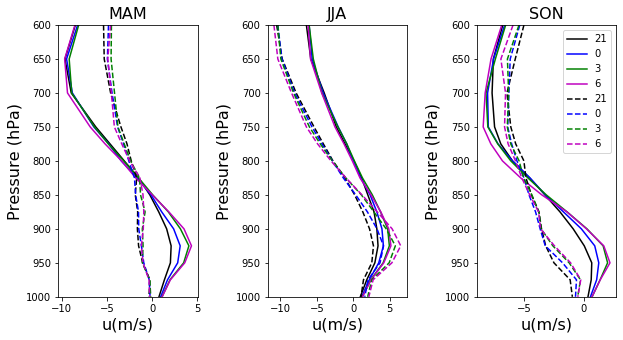

In [5]:
#u = wind_uv_speed(A.u, A.v)
u = JetDs.u
u_south = u.sel(longitude = slice(-10,10), latitude = slice(11,5)).mean(['longitude','latitude'])
u_north = u.sel(longitude = slice(-15,20), latitude = slice(17,11)).mean(['longitude','latitude'])


plt.figure(figsize = (10,5))
plt.subplots_adjust(wspace = 0.5)
colors = ['k', 'b', 'g', 'm']
season = ['MAM', 'JJA', 'SON']

for i, seas in enumerate(season):
    for li, loc in enumerate([u_south, u_north]):
        plt.subplot(1,3,i+1)
        plt.title(season[i], fontsize = 16)
        for r, s in enumerate([21, 0, 3, 6]):
            if li == 0:
                vertical_plot(loc, seas, '-')
            elif li ==1:
                vertical_plot(loc, seas, '--')
            plt.ylim(1000,600)
            #plt.axvline(x=0, color = 'k', linestyle = 'dashed')
            
plt.legend()
#plt.savefig('2016_WA_NLLJ_vertical profile.png')

***

## **2016 NLLJ VARIATION OVER WEST AFRICA AT 925 LEVEL**

***

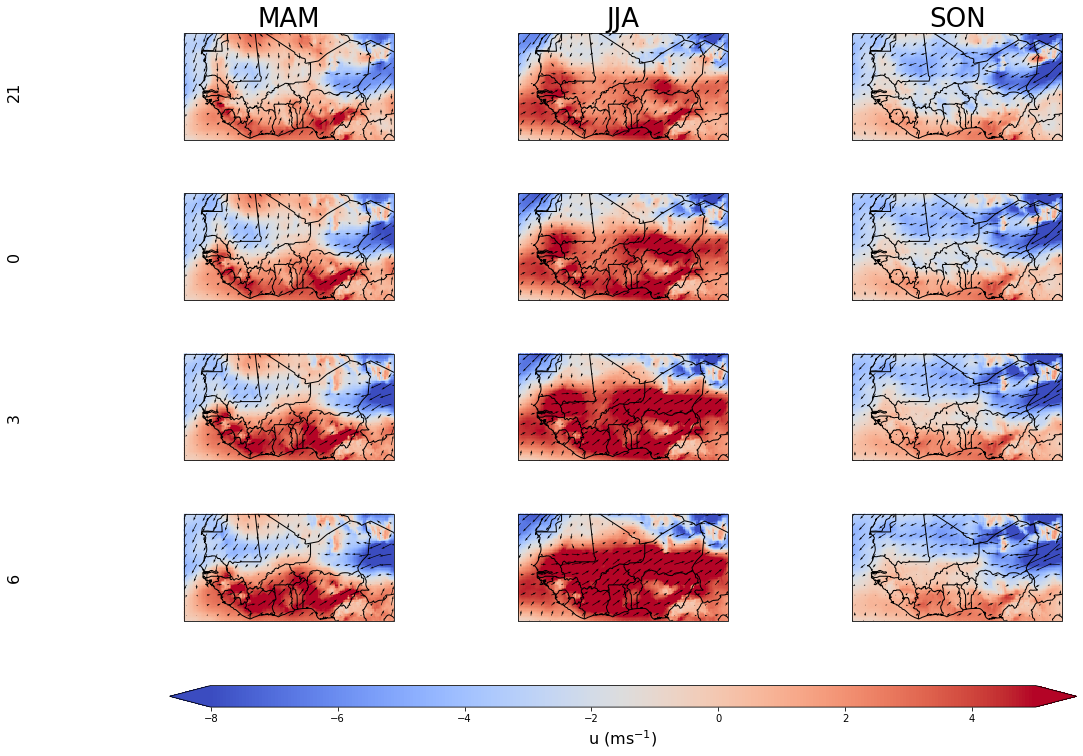

In [6]:
NLLJ_ds = collections.defaultdict(list)
for t in [21, 0, 3, 6]:
        NLLJ_ds[str(t)].append(JetDs.sel(level = 925, time = hour_select(JetDs['time.hour'], t)))


fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18,12), subplot_kw={'projection': ccrs.PlateCarree()}) 
fig.subplots_adjust(hspace=0.5, wspace=0.4, left=0.2, bottom=0.2)

for r,s in enumerate([21,0,3,6]):
    for seas_ind, season in enumerate(['MAM','JJA','SON']):
        
        u = NLLJ_ds[str(s)][0].u
        v = NLLJ_ds[str(s)][0].v
        x = NLLJ_ds[str(s)][0].longitude
        y = NLLJ_ds[str(s)][0].latitude
        
        u = u.where(u['time.season'] == season, drop=True).mean('time')        
        v = v.where(v['time.season'] == season, drop=True).mean('time')
        

        cb = u.plot(vmax=5,vmin=-8, cmap='coolwarm', ax = axes[r, seas_ind], add_colorbar=False)
        
        axes[r, seas_ind].set_xlabel('longitude')
        axes[r, seas_ind].set_ylabel('latitude')
        axes[r, seas_ind].quiver(x[::8],y[::8], u[::8,::8], v[::8,::8])
        axes[r, seas_ind].coastlines()
        axes[r, seas_ind].add_feature(cf.BORDERS)
        axes[r, seas_ind].set_extent([-20.5,20.5,4,23.5])
        

        if r == 0:
            axes[r, seas_ind].set_title(season, fontsize=26)
        else:
            axes[r, seas_ind].set_title('')
            
        if seas_ind == 0:
            axes[r, seas_ind].text(-55, 12, str(s), fontsize=16, rotation=90)
            

cax = fig.add_axes([0.2, 0.1, 0.7, 0.025])
cbar = fig.colorbar(cb, cax=cax, orientation='horizontal', extend='both')
cbar.set_label('u (ms$^{-1}$)', fontsize=16)

#plt.savefig('2016_WA_NLLJ_925_plot.png')

***

## **2016 RELATIVE HUMIDITY OVER WEST AFRICA AT 925 LEVEL**

***

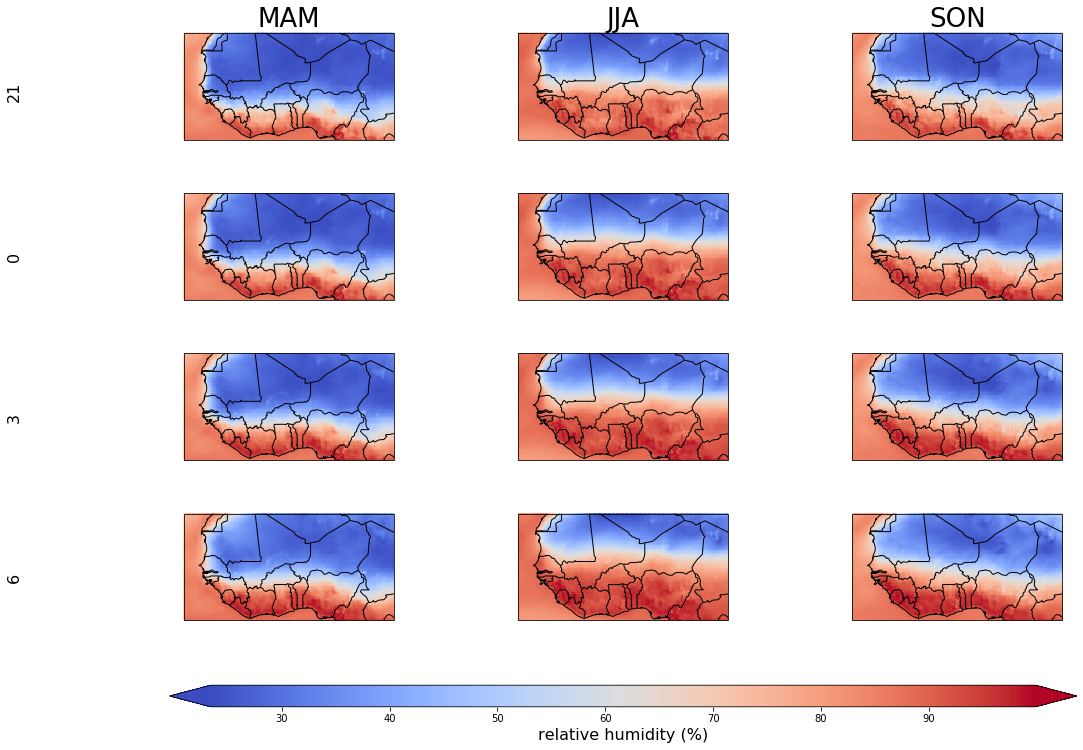

In [7]:
RH_dict = collections.defaultdict(list)
for t in [21, 0, 3, 6]:
        RH_dict[str(t)].append(RH_ds.sel(level = 1000, time = hour_select(RH_ds['time.hour'], t)))



fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18,12), subplot_kw={'projection': ccrs.PlateCarree()}) 
fig.subplots_adjust(hspace=0.5, wspace=0.4, left=0.2, bottom=0.2)

for a,b in enumerate([21,0,3,6]):
    for seas_ind, season in enumerate(['MAM','JJA','SON']):
        
        r = RH_dict[str(b)][0].r
        v = RH_dict[str(b)][0].r
        x = RH_dict[str(b)][0].longitude
        y = RH_dict[str(b)][0].latitude
        
        r = r.where(r['time.season'] == season, drop=True).mean('time')
        
        cb = r.plot(cmap='coolwarm', ax = axes[a, seas_ind], add_colorbar=False)
        
        
        axes[a, seas_ind].coastlines()
        axes[a, seas_ind].add_feature(cf.BORDERS)
        axes[a, seas_ind].set_extent([-20.5,20.5,4,23.5])
        
        axes[a, seas_ind].set_xlabel('longitude')
        axes[a, seas_ind].set_ylabel('latitude')
                                 
        if a == 0:
            axes[a, seas_ind].set_title(season, fontsize=26)
        else:
            axes[a, seas_ind].set_title('')
            
        if seas_ind == 0:
            axes[a, seas_ind].text(-55, 12, str(b), fontsize=16, rotation=90)
            

cax = fig.add_axes([0.2, 0.1, 0.7, 0.025])
cbar = fig.colorbar(cb, cax=cax, orientation='horizontal', extend='both')
cbar.set_label('relative humidity (%)', fontsize=16)

#plt.savefig('2016_WA_RH_925_plot.png')

***
## **CORRELATION COEFFICIENT BETWEEN RH AND NLLJ OVER WEST AFRICA IN 2016**
***

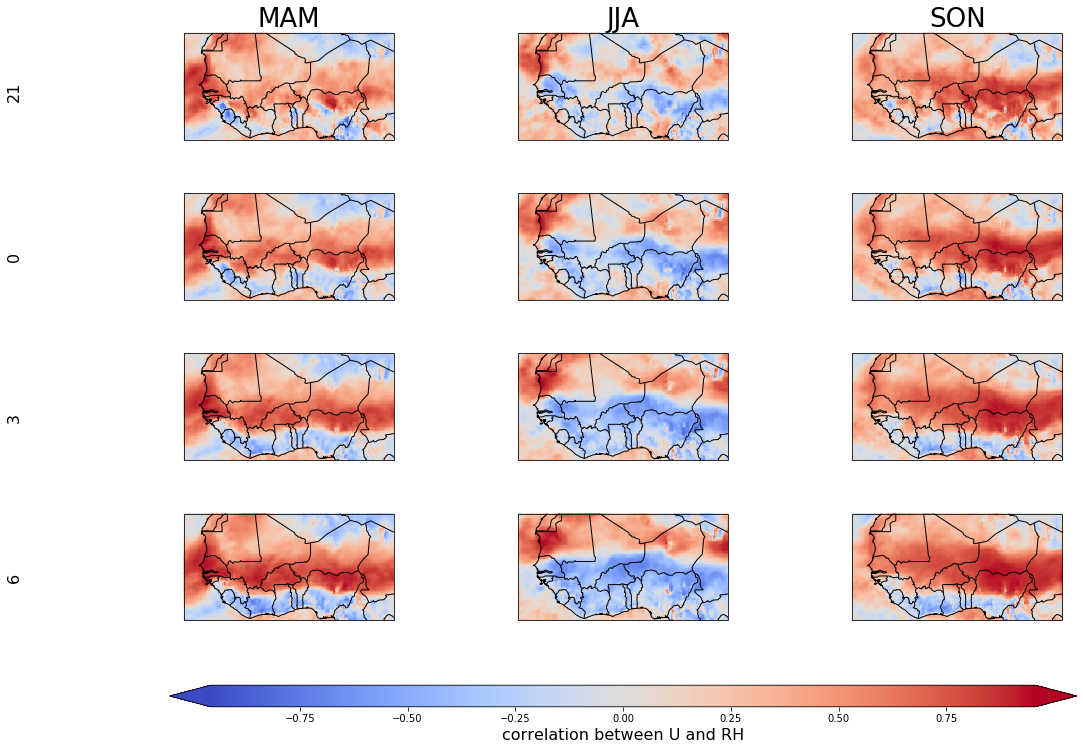

In [24]:
mypalette =('#bf8046', '#df9f24', '#e0de30', '#c1de2d', '#1ebf82','#23de27', '#1dbe20', '#11807f', '#24607f', '#22427e')
levels = range(-1, 1)
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18,12), subplot_kw={'projection': ccrs.PlateCarree()}) 
fig.subplots_adjust(hspace=0.5, wspace=0.4, left=0.2, bottom=0.2)

for r,s in enumerate([21,0,3,6]):
    for seas_ind, season in enumerate(['MAM','JJA','SON']):
        
        u = NLLJ_ds[str(s)][0].u
        v = RH_dict[str(s)][0].r
        
        u_variable = u.where(u['time.season'] == season, drop=True)        
        v_variable = v.where(v['time.season'] == season, drop=True)
        
        cc = correlation(u_variable, v_variable, dim='time')
        

        cb = cc.plot(cmap = 'coolwarm', ax = axes[r, seas_ind], add_colorbar=False)
        
        axes[r, seas_ind].set_xlabel('longitude')
        axes[r, seas_ind].set_ylabel('latitude')
        axes[r, seas_ind].coastlines()
        axes[r, seas_ind].add_feature(cf.BORDERS)
        axes[r, seas_ind].set_extent([-20.5,20.5,4,23.5])
        

        if r == 0:
            axes[r, seas_ind].set_title(season, fontsize=26)
        else:
            axes[r, seas_ind].set_title('')
            
        if seas_ind == 0:
            axes[r, seas_ind].text(-55, 12, str(s), fontsize=16, rotation=90)
            

cax = fig.add_axes([0.2, 0.1, 0.7, 0.025])
cbar = fig.colorbar(cb, cax=cax, orientation='horizontal', extend='both')
cbar.set_label('correlation between U and RH', fontsize=16)

#plt.savefig('2016_WA_correlation between RH and U_925_plot.png')